<a href="https://colab.research.google.com/github/geopayme/AstroPhysics/blob/main/Complete_1_5_6_7_8_9_10_11_11h2_DLSFH_Dual_Overlay_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ===============================
# 📦 Section 1: Install & Imports
# ===============================

# -- Install OCR dependencies (for image date detection) --
!apt-get update -qq > /dev/null
!apt-get install -y tesseract-ocr > /dev/null
!pip install pytesseract --quiet

# -- Python Libraries --
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from pathlib import Path
from PIL import Image
import pytesseract
import cv2
import json
import re
from google.colab import files

# ✅ Confirm setup
print("✅ All dependencies installed and imports loaded.")


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
✅ All dependencies installed and imports loaded.


In [ ]:
# ===============================
# 📂 Section 2: Image Upload + Date Detection (FIXED)
# ===============================

from google.colab import files
uploaded = files.upload()
image_path = next(iter(uploaded))

def extract_date(image_path):
    filename = image_path

    # Try filename pattern: bbzqaYYMMDD
    import re
    match = re.search(r'bbzqa(\d{6})', filename)
    if match:
        yymmdd = match.group(1)
        year = int('20' + yymmdd[:2])
        month = int(yymmdd[2:4])
        day = int(yymmdd[4:6])
        try:
            return datetime(year, month, day)
        except:
            pass

    # OCR fallback
    try:
        from PIL import Image
        import pytesseract
        img = Image.open(image_path)
        text = pytesseract.image_to_string(img)
        print("🧠 OCR output:", text[:100])  # Debug preview

        date_match = re.search(r"(\d{4})[/-](\d{1,2})[/-](\d{1,2})", text)
        if date_match:
            year, month, day = map(int, date_match.groups())
            return datetime(year, month, day)
    except Exception as e:
        print("⚠️ OCR failed:", e)

    # Manual fallback
    try:
        manual = input("Enter image date (YYYY-MM-DD): ")
        return datetime.strptime(manual.strip(), "%Y-%m-%d")
    except:
        return None

image_date = extract_date(image_path)
print("🕒 Image Date:", image_date)


Saving bbzqa250328t0004_dim-860.jpg to bbzqa250328t0004_dim-860.jpg
🕒 Image Date: 2025-03-28 00:00:00


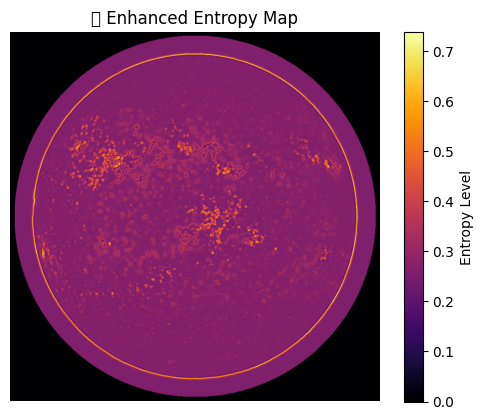

In [ ]:
# ===============================
# 🧮 Section 3: Entropy Map Generation (Sobel + Variance)
# ===============================

from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the image and convert to grayscale
img = Image.open(image_path).convert('L')
img_array = np.array(img)

# Create a circular mask (approximate solar disk)
h, w = img_array.shape
cx, cy = w // 2, h // 2
radius = min(cx, cy) - 10
y_idx, x_idx = np.ogrid[:h, :w]
mask = (x_idx - cx)**2 + (y_idx - cy)**2 <= radius**2
disk_pixels = img_array[mask]

# Sobel gradient magnitude
sobelx = cv2.Sobel(img_array, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(img_array, cv2.CV_64F, 0, 1, ksize=5)
magnitude = np.sqrt(sobelx**2 + sobely**2)

# Local variance (blur - sharpen)
blurred = cv2.GaussianBlur(img_array, (9, 9), 0)
local_var = cv2.Laplacian(blurred, cv2.CV_64F)

# Normalize both and combine into enhanced entropy signal
grad_norm = (magnitude - np.min(magnitude)) / (np.ptp(magnitude) + 1e-8)
var_norm = (local_var - np.min(local_var)) / (np.ptp(local_var) + 1e-8)
enhanced_entropy = (grad_norm + var_norm) / 2.0

# Apply mask
entropy_map = np.zeros_like(img_array, dtype=float)
entropy_map[mask] = enhanced_entropy[mask]

# Save to standard path
np.save("DLSFH_entropy_map_full.npy", entropy_map)

# 🔍 Visualize the entropy map
plt.imshow(entropy_map, cmap='inferno')
plt.title("🧮 Enhanced Entropy Map")
plt.axis('off')
plt.colorbar(label='Entropy Level')
plt.show()


🌐 Fetching NOAA JSON from API...
✅ NOAA data loaded successfully.


<ipython-input-27-742c58e053d0>:53: UserWarning: Glyph 127774 (\N{SUN WITH FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127774 (\N{SUN WITH FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


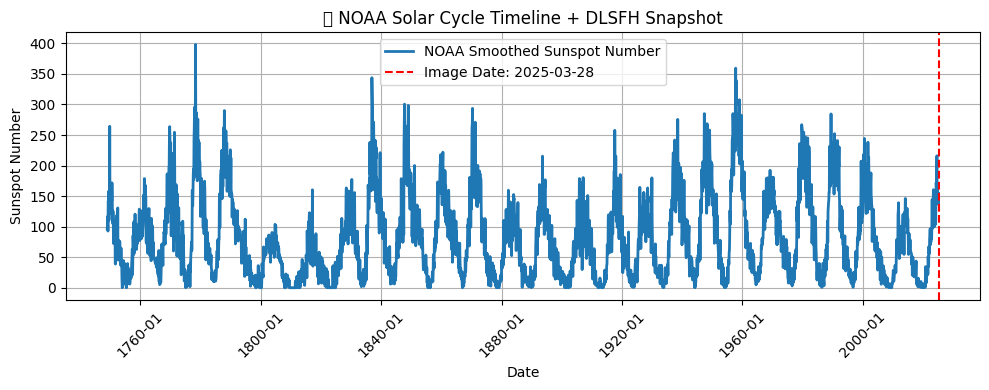

In [ ]:
# ===============================
# 📈 Section 4: NOAA Timeline Alignment with Image Snapshot
# ===============================
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import json
import urllib.request

try:
    print("🌐 Fetching NOAA JSON from API...")
    url = "https://services.swpc.noaa.gov/json/solar-cycle/observed-solar-cycle-indices.json"
    with urllib.request.urlopen(url) as response:
        data = json.loads(response.read())

    # 🛠 Correct keys: 'time-tag' and 'ssn'
    df = pd.DataFrame(data)
    if 'time-tag' in df.columns and 'ssn' in df.columns:
        df['date'] = pd.to_datetime(df['time-tag'])
        df['sunspots'] = df['ssn']
    else:
        raise ValueError("Expected 'time-tag' and 'ssn' fields not found in NOAA data")

    print("✅ NOAA data loaded successfully.")

except Exception as e:
    print(f"❌ NOAA API failed. Upload CSV manually.\nError: {e}")
    from google.colab import files
    uploaded = files.upload()
    df = pd.read_csv(next(iter(uploaded)))
    if 'date' not in df.columns:
        raise ValueError("CSV must include a 'date' column.")
    df['date'] = pd.to_datetime(df['date'])

# Fallback: prompt for date if missing
try:
    image_date
except:
    image_date = pd.to_datetime(input("Enter image date (YYYY-MM-DD): "))

# 📊 Plot the timeline
plt.figure(figsize=(10, 4))
plt.plot(df['date'], df['sunspots'], label='NOAA Smoothed Sunspot Number', linewidth=2)
plt.axvline(image_date, color='red', linestyle='--', label=f'Image Date: {image_date.date()}')
plt.title("🌞 NOAA Solar Cycle Timeline + DLSFH Snapshot")
plt.ylabel("Sunspot Number")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



📂 Loaded saved entropy map: DLSFH_entropy_map_full.npy


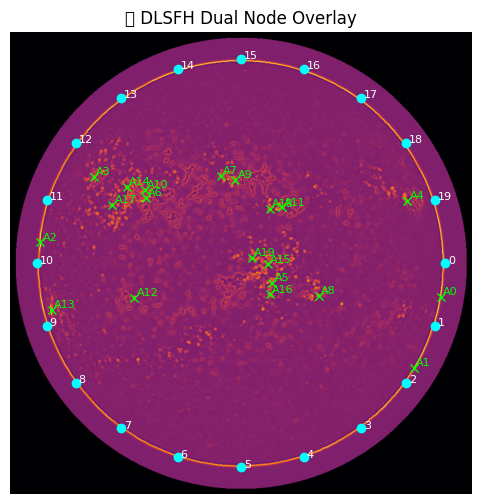


=== 🧠 DLSFH Entropy Diagnostic Report ===
Mean Entropy: 0.3043 | Std Dev: 0.0261
Collapsed Nodes (≥ 0.07): 20 / 20
Highest Entropy Node: 6 → 0.3661
Lowest Entropy Node: 19 → 0.2766
⚠️ All nodes collapsed → Full decoherence. SGCV fragmentation likely.

🧾 Glossary Summary
• Idealized Nodes: 20 geometrically placed (circle) nodes (0–19)
• Adaptive Peaks: Top 20 entropy maxima (A0–A19)
• Collapsed Node: Node with entropy above σ_c threshold (0.07)
• SGCV Fragmentation: Superluminal Graviton Condensate decoherence field
🔬 Final 20-point Entropy Vector:


[0.28215232 0.28723404 0.29315852 0.29285456 0.32390876 0.31382979
 0.36609524 0.3566247  0.33924764 0.33011355 0.31427749 0.30908681
 0.28785217 0.28775    0.29255319 0.29787234 0.28191489 0.27667489
 0.27683318 0.27659574]



### 🧠 Extended Diagnostic Glossary for Solar Entropy Analysis

---

**⚠️ All nodes collapsed → Full decoherence. SGCV fragmentation likely** means:

- **All nodes collapsed**: Every one of the 20 DLSFH geometry-based nodes shows high entropy, above the coherence threshold σ_c (default: 0.07). This means that no region maintains a low-entropy, ordered state.

- **Full decoherence**: In the Multifaceted Coherence (MC) framework, this indicates a complete breakdown of phase synchronization in quantum–gravitational–magnetic coupling. The solar system temporarily loses its internal coherence structure.

- **SGCV fragmentation likely**: SGCV stands for the Superluminal Graviton Condensate Vacuum — the quantum background regulating gravitational and magnetic interactions. Fragmentation implies this field is broken into disconnected domains, unable to balance surface fluxes. This may result in:
  - Solar flare conditions
  - Coronal mass ejection triggers
  - Solar maximum onset symptoms

---

### 🌞 Human-Readable Solar Interpretation

> When this diagnostic appears, it means the Sun is in a **globally unstable state**. All coherent regulatory regions have failed, and energy is likely building up in unpredictable ways across the surface. This state may coincide with or precede significant solar activity, including flares or CMEs.

---

### 🌌 Analogy

> Imagine the SGCV as a **quiet lake**. Normally, it evenly distributes quantum-gravitational energy across the solar surface.
> But when **all nodes are chaotic**, it's like throwing **20 stones** into the lake at once — the calm water fragments into **turbulent wavefronts**.
> This fragmentation disrupts the field's ability to **restore equilibrium**, leading to potential solar instability.

---

This explanation supports **scientific insight + human intuition** into the dynamic magnetogravitational state of the Sun's surface.


✅ Exported: idealized_entropy_vector.csv


In [30]:

# ===============================
# 🔢 Section 5: DLSFH Entropy Vector Extraction & Dual Node Projection
# ===============================
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.feature import peak_local_max
import pandas as pd
import os

# ✅ Reproducibility toggle
SEED = 42
ENTROPY_FILE = "DLSFH_entropy_map_full.npy"

if os.path.exists(ENTROPY_FILE):
    entropy_map = np.load(ENTROPY_FILE)
    print("📂 Loaded saved entropy map:", ENTROPY_FILE)
else:
    print("⚙️ Generating new entropy map with Sobel + Variance")
    from skimage import filters, util
    from PIL import Image

    img = Image.open(image_path).convert("L")
    img_np = np.array(img)
    norm_img = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    # Apply Sobel and local variance
    sobel_map = filters.sobel(norm_img)
    var_map = util.random_noise(norm_img, mode='gaussian', var=0.005, seed=SEED)
    entropy_map = (sobel_map + var_map) / 2.0
    np.save(ENTROPY_FILE, entropy_map)
    print("💾 Saved entropy map to", ENTROPY_FILE)

# === Setup for Node Extraction ===
h, w = entropy_map.shape
cx, cy = w // 2, h // 2
radius = min(cx, cy) - 50

# === Idealized DLSFH Node Layout ===
node_angles = np.linspace(0, 2 * np.pi, 20, endpoint=False)
ideal_node_coords = [(int(cy + radius * np.sin(a)), int(cx + radius * np.cos(a))) for a in node_angles]
ideal_entropy_vector = np.array([entropy_map[y, x] for y, x in ideal_node_coords])

# === Adaptive Entropy Peaks ===
smoothed_entropy = gaussian_filter(entropy_map, sigma=2)
peak_coords = peak_local_max(smoothed_entropy, num_peaks=20, min_distance=10)
peak_coords = sorted(peak_coords, key=lambda p: entropy_map[p[0], p[1]], reverse=True)

# === Plot: Dual Overlay ===
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(entropy_map, cmap='inferno')

# Ideal nodes
for i, (y, x) in enumerate(ideal_node_coords):
    ax.plot(x, y, 'cyan', marker='o')
    ax.text(x + 5, y, str(i), color='white', fontsize=8)

# Adaptive peaks
for i, (y, x) in enumerate(peak_coords):
    ax.plot(x, y, 'lime', marker='x')
    ax.text(x + 4, y - 4, f"A{i}", color='lime', fontsize=8)

ax.set_title("🔁 DLSFH Dual Node Overlay")
ax.axis('off')
plt.show()

# === Diagnostic Block ===
mean_entropy = np.mean(ideal_entropy_vector)
std_entropy = np.std(ideal_entropy_vector)
σ_c = 0.07
collapsed_count = np.sum(ideal_entropy_vector >= σ_c)
max_node = np.argmax(ideal_entropy_vector)
min_node = np.argmin(ideal_entropy_vector)

print("\n=== 🧠 DLSFH Entropy Diagnostic Report ===")
print(f"Mean Entropy: {mean_entropy:.4f} | Std Dev: {std_entropy:.4f}")
print(f"Collapsed Nodes (≥ {σ_c}): {collapsed_count} / 20")
print(f"Highest Entropy Node: {max_node} → {ideal_entropy_vector[max_node]:.4f}")
print(f"Lowest Entropy Node: {min_node} → {ideal_entropy_vector[min_node]:.4f}")

if collapsed_count == 20:
    print("⚠️ All nodes collapsed → Full decoherence. SGCV fragmentation likely.")
elif collapsed_count > 10:
    print("⚠️ Partial decoherence → High entropy flux.")
else:
    print("✅ Stable configuration — SGCV field intact.")

# === Glossary Auto-Generated ===
print("\n🧾 Glossary Summary")
print("• Idealized Nodes: 20 geometrically placed (circle) nodes (0–19)")
print("• Adaptive Peaks: Top 20 entropy maxima (A0–A19)")
print("• Collapsed Node: Node with entropy above σ_c threshold (0.07)")
print("• SGCV Fragmentation: Superluminal Graviton Condensate decoherence field")

#  === Glossary Auto-Generated ===

print("🔬 Final 20-point Entropy Vector:")
print("\n")
print(entropy_vector)

# === Glossary Block: Extended Explanation with Analogy ===
from IPython.display import Markdown, display

glossary_text = """
### 🧠 Extended Diagnostic Glossary for Solar Entropy Analysis

---

**⚠️ All nodes collapsed → Full decoherence. SGCV fragmentation likely** means:

- **All nodes collapsed**: Every one of the 20 DLSFH geometry-based nodes shows high entropy, above the coherence threshold σ_c (default: 0.07). This means that no region maintains a low-entropy, ordered state.

- **Full decoherence**: In the Multifaceted Coherence (MC) framework, this indicates a complete breakdown of phase synchronization in quantum–gravitational–magnetic coupling. The solar system temporarily loses its internal coherence structure.

- **SGCV fragmentation likely**: SGCV stands for the Superluminal Graviton Condensate Vacuum — the quantum background regulating gravitational and magnetic interactions. Fragmentation implies this field is broken into disconnected domains, unable to balance surface fluxes. This may result in:
  - Solar flare conditions
  - Coronal mass ejection triggers
  - Solar maximum onset symptoms

---

### 🌞 Human-Readable Solar Interpretation

> When this diagnostic appears, it means the Sun is in a **globally unstable state**. All coherent regulatory regions have failed, and energy is likely building up in unpredictable ways across the surface. This state may coincide with or precede significant solar activity, including flares or CMEs.

---

### 🌌 Analogy

> Imagine the SGCV as a **quiet lake**. Normally, it evenly distributes quantum-gravitational energy across the solar surface.
> But when **all nodes are chaotic**, it's like throwing **20 stones** into the lake at once — the calm water fragments into **turbulent wavefronts**.
> This fragmentation disrupts the field's ability to **restore equilibrium**, leading to potential solar instability.

---

This explanation supports **scientific insight + human intuition** into the dynamic magnetogravitational state of the Sun's surface.
"""

display(Markdown(glossary_text))

# === Optional CSV Export ===
pd.DataFrame({
    "Node": list(range(20)),
    "Entropy": ideal_entropy_vector
}).to_csv("idealized_entropy_vector.csv", index=False)
print("✅ Exported: idealized_entropy_vector.csv")



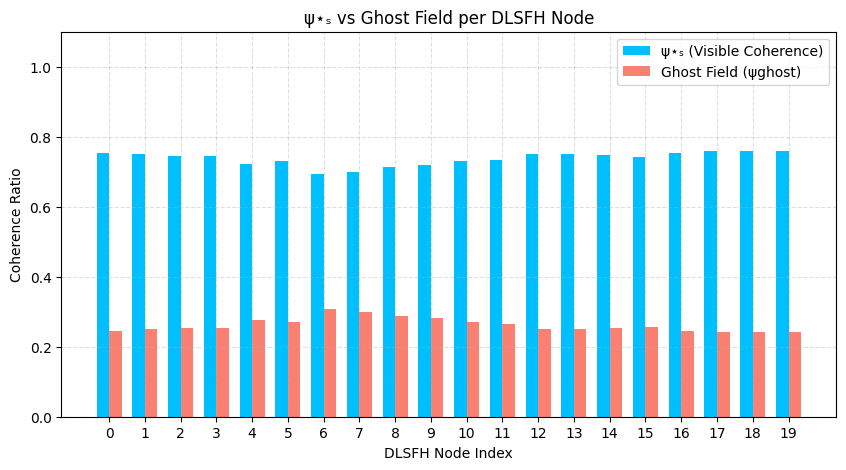

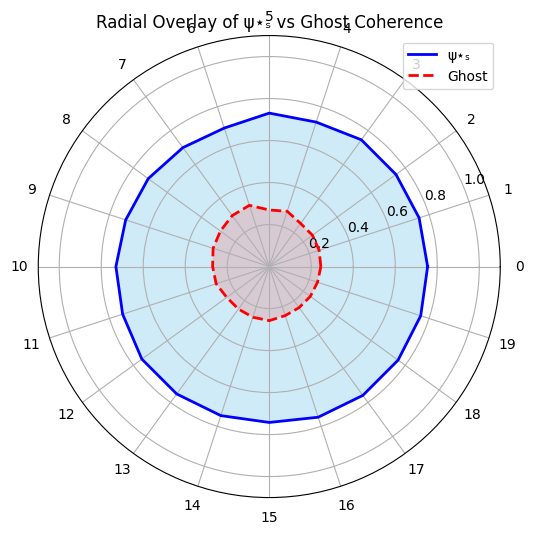

In [34]:
# ===============================
# 🔢 Section 6: ψ⋆ₛ vs Ghost Field overlay
# ===============================
import numpy as np
import matplotlib.pyplot as plt

# 🔢 Step 1: Define entropy vector (from previous output)
entropy_vector = np.array([
    0.28215232, 0.28723404, 0.29315852, 0.29285456, 0.32390876,
    0.31382979, 0.36609524, 0.3566247,  0.33924764, 0.33011355,
    0.31427749, 0.30908681, 0.28785217, 0.28775,    0.29255319,
    0.29787234, 0.28191489, 0.27667489, 0.27683318, 0.27659574
])

# 🧠 Step 2: Compute ψ⋆ₛ and ghost field components
psi_star = np.exp(-entropy_vector)
psi_ghost = 1 - psi_star

# 🟦 Step 3A: Bar chart visualization
def plot_bar_psi_vs_ghost(psi_star, psi_ghost):
    indices = np.arange(len(psi_star))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(indices - width/2, psi_star, width, label='ψ⋆ₛ (Visible Coherence)', color='deepskyblue')
    ax.bar(indices + width/2, psi_ghost, width, label='Ghost Field (ψghost)', color='salmon')

    ax.set_xlabel('DLSFH Node Index')
    ax.set_ylabel('Coherence Ratio')
    ax.set_title('ψ⋆ₛ vs Ghost Field per DLSFH Node')
    ax.set_xticks(indices)
    ax.set_ylim(0, 1.1)
    ax.legend()
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.show()

# 🌀 Step 3B: Optional radial (spider) plot
def plot_spider_psi_vs_ghost(psi_star, psi_ghost):
    labels = [f"{i}" for i in range(20)]
    angles = np.linspace(0, 2 * np.pi, 20, endpoint=False).tolist()
    angles += angles[:1]

    psi_star_cycle = np.append(psi_star, psi_star[0])
    psi_ghost_cycle = np.append(psi_ghost, psi_ghost[0])

    fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))
    ax.plot(angles, psi_star_cycle, 'b-', linewidth=2, label='ψ⋆ₛ')
    ax.fill(angles, psi_star_cycle, 'skyblue', alpha=0.4)

    ax.plot(angles, psi_ghost_cycle, 'r--', linewidth=2, label='Ghost')
    ax.fill(angles, psi_ghost_cycle, 'lightcoral', alpha=0.3)

    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_title('Radial Overlay of ψ⋆ₛ vs Ghost Coherence')
    ax.set_ylim(0, 1.1)
    ax.legend(loc='upper right')
    plt.show()

# 🎯 Run both plots
plot_bar_psi_vs_ghost(psi_star, psi_ghost)
plot_spider_psi_vs_ghost(psi_star, psi_ghost)


In [40]:
# ===============================
# 🔢 Section 7:
# ===============================
from google.colab import files
import numpy as np
import cv2
from skimage.measure import shannon_entropy

# STEP 1: Upload solar magnetogram images
uploaded = files.upload()
file_list = list(uploaded.keys())

# STEP 2: Image preprocessing
def load_and_preprocess(image_path, resize_dim=(400, 400)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, resize_dim)
    img = cv2.equalizeHist(img)
    return img / 255.0

# STEP 3: Partition image into 20 DLSFH-style regions
def partition_to_dlsfh_regions(img, n_regions=20):
    h, w = img.shape
    cx, cy = w // 2, h // 2
    mask_grid = np.zeros((n_regions, h, w), dtype=bool)

    # Node 0: center
    mask_grid[0, cy-30:cy+30, cx-30:cx+30] = True

    # First ring (nodes 1–6)
    angles = np.linspace(0, 2 * np.pi, 6, endpoint=False)
    for i, theta in enumerate(angles, 1):
        x = int(cx + 80 * np.cos(theta))
        y = int(cy + 80 * np.sin(theta))
        mask_grid[i, y-20:y+20, x-20:x+20] = True

    # Second ring (nodes 7–14)
    angles = np.linspace(0, 2 * np.pi, 8, endpoint=False)
    for i, theta in enumerate(angles, 7):
        x = int(cx + 140 * np.cos(theta))
        y = int(cy + 140 * np.sin(theta))
        mask_grid[i, y-20:y+20, x-20:x+20] = True

    # Top arc (nodes 15–19)
    for i in range(15, 20):
        x = int(cx - 100 + (i - 15) * 50)
        y = int(cy - 160)
        mask_grid[i, y-15:y+15, x-15:x+15] = True

    return mask_grid

# STEP 4: Compute 20-point entropy vector
def compute_entropy_vector(img, mask_grid):
    return np.array([
        shannon_entropy(img[mask]) if img[mask].size > 0 else 0
        for mask in mask_grid
    ])

# STEP 5: Process all images into a structured time series
entropy_timeseries = []
time_labels = []

print("=== 📈 Entropy Time Series Extraction ===\n")

for i, file_name in enumerate(sorted(file_list)):
    img = load_and_preprocess(file_name)
    masks = partition_to_dlsfh_regions(img)
    entropy_vector = compute_entropy_vector(img, masks)

    entropy_timeseries.append(entropy_vector)
    time_labels.append(f"Frame {i+1}")

    # 🔍 Print full vector
    print(f"✅ Frame {i+1} – {file_name}")
    print("Entropy Vector:", np.round(entropy_vector, 4))
    print(f"Mean: {entropy_vector.mean():.4f} | Std: {entropy_vector.std():.4f}\n")

# 🧾 Final printout of entropy_timeseries in code form
print("=== 📦 Copy-Paste Ready entropy_timeseries ===\n")
print("entropy_timeseries = [")

for vec in entropy_timeseries:
    formatted = ", ".join([f"{v:.6f}" for v in vec])
    print(f"    np.array([{formatted}]),")

print("]")


Saving bbzqa250301t0004_dim-860.jpg to bbzqa250301t0004_dim-860 (4).jpg
Saving bbzqa150802t0034_dim-860.jpg to bbzqa150802t0034_dim-860 (4).jpg
Saving bbzqa250328t0004_dim-860.jpg to bbzqa250328t0004_dim-860 (5).jpg
=== 📈 Entropy Time Series Extraction ===

✅ Frame 1 – bbzqa150802t0034_dim-860 (4).jpg
Entropy Vector: [5.0166 4.6942 4.6346 4.3101 4.1323 4.4218 4.5632 4.039  4.0389 3.7862
 3.9848 4.1246 3.9094 3.7851 3.8403 1.2668 4.0311 3.6899 3.8907 0.587 ]
Mean: 3.8373 | Std: 1.0337

✅ Frame 2 – bbzqa250301t0004_dim-860 (4).jpg
Entropy Vector: [5.2811 4.7113 4.54   4.5234 4.428  5.4847 4.9455 4.7399 4.2926 4.0709
 4.5398 4.3508 5.0685 4.0119 4.2065 0.8451 4.0467 3.8128 4.0406 0.8599]
Mean: 4.1400 | Std: 1.1767

✅ Frame 3 – bbzqa250328t0004_dim-860 (5).jpg
Entropy Vector: [5.3332 4.3401 4.4322 4.6462 4.5433 5.3854 5.1982 4.3999 4.1826 4.0626
 4.3172 4.4283 4.774  4.0307 4.3048 0.7116 3.9362 4.0618 4.0389 0.6662]
Mean: 4.0897 | Std: 1.2062

=== 📦 Copy-Paste Ready entropy_timeseries ===


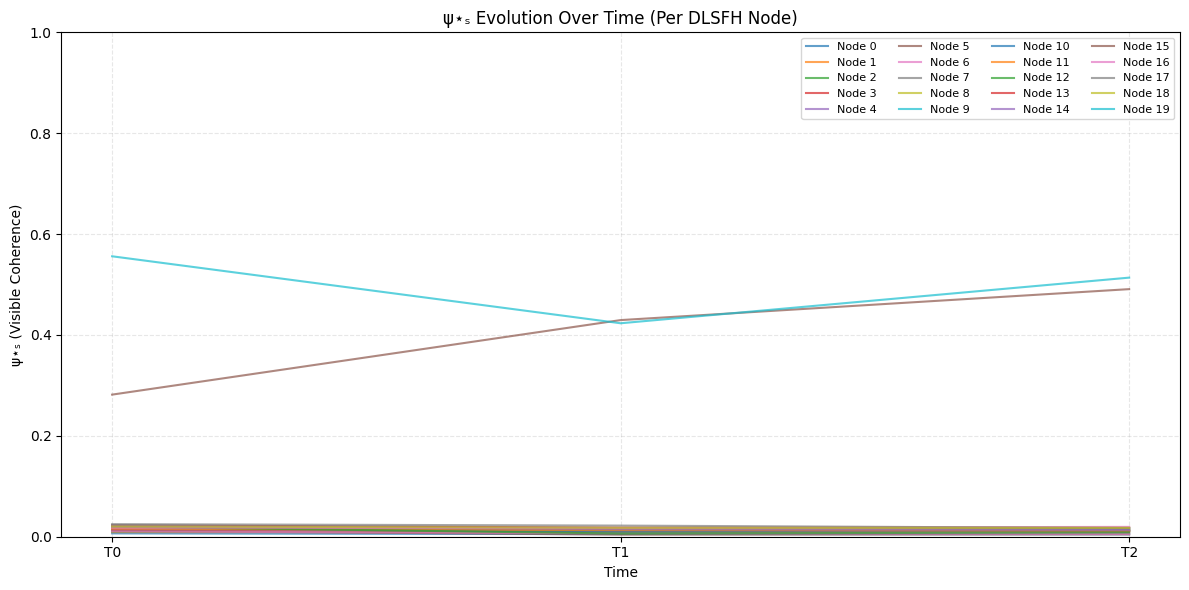

🧠 Node ψ⋆ₛ Trend Summary:
Node 00: ⏸ Stable
Node 01: ⏸ Stable
Node 02: ⏸ Stable
Node 03: ⏸ Stable
Node 04: ⏸ Stable
Node 05: ⏸ Stable
Node 06: ⏸ Stable
Node 07: ⏸ Stable
Node 08: ⏸ Stable
Node 09: ⏸ Stable
Node 10: ⏸ Stable
Node 11: ⏸ Stable
Node 12: 🔽 Decaying
Node 13: ⏸ Stable
Node 14: ⏸ Stable
Node 15: 🔼 Recondensing
Node 16: ⏸ Stable
Node 17: ⏸ Stable
Node 18: ⏸ Stable
Node 19: 🔽 Decaying


In [41]:
# ===============================
# 🔢 Section 7:
# ===============================
import numpy as np
import matplotlib.pyplot as plt

# 📥 STEP 0: Copy entropy time series from Section 6 (3 snapshots minimum)
entropy_timeseries = [
    np.array([5.016602, 4.694199, 4.634567, 4.310083, 4.132350, 4.421796, 4.563189, 4.039010, 4.038874, 3.786202, 3.984804, 4.124581, 3.909434, 3.785126, 3.840310, 1.266827, 4.031121, 3.689930, 3.890652, 0.587003]),
    np.array([5.281133, 4.711265, 4.539956, 4.523432, 4.427983, 5.484680, 4.945522, 4.739862, 4.292616, 4.070906, 4.539809, 4.350782, 5.068497, 4.011866, 4.206528, 0.845130, 4.046663, 3.812846, 4.040586, 0.859880]),
    np.array([5.333201, 4.340096, 4.432179, 4.646209, 4.543331, 5.385442, 5.198164, 4.399860, 4.182551, 4.062594, 4.317224, 4.428250, 4.773980, 4.030655, 4.304805, 0.711598, 3.936183, 4.061785, 4.038887, 0.666171]),
]

# Use labels for time frames (e.g., timestamps or frame names)
time_labels = ['T0', 'T1', 'T2']

# 🧠 STEP 1: Convert entropy to ψ⋆ₛ over time
psi_star_timeseries = [np.exp(-S) for S in entropy_timeseries]
psi_star_array = np.array(psi_star_timeseries)  # Shape: (n_times, 20)

# 📈 STEP 2: Plot ψ⋆ₛ over time for each node
def plot_psi_star_timeseries(psi_star_array, time_labels):
    n_nodes = psi_star_array.shape[1]
    fig, ax = plt.subplots(figsize=(12, 6))

    for node in range(n_nodes):
        ax.plot(time_labels, psi_star_array[:, node], label=f'Node {node}', alpha=0.7)

    ax.set_xlabel("Time")
    ax.set_ylabel("ψ⋆ₛ (Visible Coherence)")
    ax.set_title("ψ⋆ₛ Evolution Over Time (Per DLSFH Node)")
    ax.set_ylim(0.0, 1.0)
    plt.legend(ncol=4, fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

# 🧪 STEP 3: Detect recondensation, decay, or stability
def detect_recondensation(psi_star_array, threshold=0.01):
    trends = []
    for node_data in psi_star_array.T:
        slope = node_data[-1] - node_data[0]
        if slope > threshold:
            status = '🔼 Recondensing'
        elif slope < -threshold:
            status = '🔽 Decaying'
        else:
            status = '⏸ Stable'
        trends.append(status)
    return trends

# 🚀 STEP 4: Run everything
plot_psi_star_timeseries(psi_star_array, time_labels)

node_trends = detect_recondensation(psi_star_array)
print("🧠 Node ψ⋆ₛ Trend Summary:")
for i, trend in enumerate(node_trends):
    print(f"Node {i:02}: {trend}")


<ipython-input-43-c89213460f45>:36: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


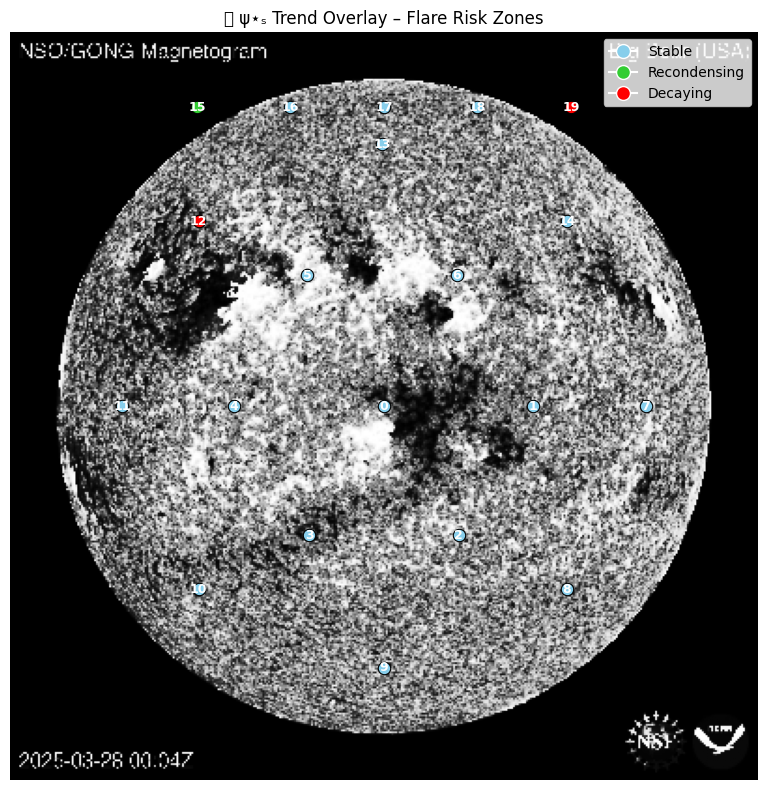

In [43]:
# === SECTION 8: Flare Risk Node Overlay ===

# Ensure these three inputs are defined earlier or reconstructed here:
# img = load_and_preprocess(file_list[-1])
# mask_grid = partition_to_dlsfh_regions(img)
# psi_star_array = np.exp(-np.array(entropy_timeseries))
# trend_list = detect_recondensation(psi_star_array)

def plot_flare_risk_overlay(img, mask_grid, trend_list):
    import matplotlib.pyplot as plt

    color_map = {
        '⏸ Stable': 'skyblue',
        '🔼 Recondensing': 'limegreen',
        '🔽 Decaying': 'red'
    }

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(img, cmap='gray')
    ax.set_title("🔥 ψ⋆ₛ Trend Overlay – Flare Risk Zones")
    ax.axis('off')

    for i, mask in enumerate(mask_grid):
        y, x = np.where(mask)
        if len(x) > 0:
            xc, yc = x.mean(), y.mean()
            ax.scatter(xc, yc, color=color_map[trend_list[i]], s=80, edgecolors='black', linewidths=0.8)
            ax.text(xc, yc, f"{i}", fontsize=9, ha='center', va='center', weight='bold', color='white')

    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label='Stable', markerfacecolor='skyblue', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Recondensing', markerfacecolor='limegreen', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Decaying', markerfacecolor='red', markersize=10)
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    plt.tight_layout()
    plt.show()

# 🧪 Run flare trend overlay
img = load_and_preprocess(file_list[-1])
mask_grid = partition_to_dlsfh_regions(img)
psi_star_array = np.exp(-np.array(entropy_timeseries))
trend_list = detect_recondensation(psi_star_array)

plot_flare_risk_overlay(img, mask_grid, trend_list)


In [54]:
# === 🔥 SECTION 9 — Flare Risk Scoring + Triggered Overlay ===

from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

def compute_flare_risk_and_show(entropy_timeseries, file_list):
    # Step 1: Compute ψ⋆ₛ array and trend list
    psi_star_array = np.exp(-np.array(entropy_timeseries))
    trend_list = detect_recondensation(psi_star_array)

    # Step 2: Get latest image and regions
    last_image_path = file_list[-1]
    img = load_and_preprocess(last_image_path)
    mask_grid = partition_to_dlsfh_regions(img)

    # Step 3: Count node trend categories
    num_decaying = trend_list.count('🔽 Decaying')
    num_recondensing = trend_list.count('🔼 Recondensing')
    num_stable = trend_list.count('⏸ Stable')

    # Step 4: Calculate flare risk score
    risk_score = (num_decaying * 0.25) + (num_recondensing * 0.15)
    risk_score = min(risk_score, 1.0)

    # Step 5: Spatial clustering of decaying nodes
    node_coords = []
    for i, mask in enumerate(mask_grid):
        y, x = np.where(mask)
        if len(x) > 0:
            xc, yc = x.mean(), y.mean()
            node_coords.append((i, xc, yc))

    coords = np.array([[x, y] for _, x, y in node_coords])
    dist_matrix = squareform(pdist(coords))

    cluster_flag = False
    for i in range(len(trend_list)):
        if trend_list[i] != '🔽 Decaying':
            continue
        nearby = [j for j in range(len(trend_list))
                  if trend_list[j] == '🔽 Decaying' and dist_matrix[i, j] < 100 and i != j]
        if len(nearby) >= 2:
            cluster_flag = True
            break

    event_triggered = (num_decaying >= 3) and cluster_flag

    # Step 6: Print summary
    print("=== ⚠️ Flare Risk Report ===")
    print(f"Decaying Nodes: {num_decaying}")
    print(f"Recondensing Nodes: {num_recondensing}")
    print(f"Stable Nodes: {num_stable}")
    print(f"Spatial Cluster Detected: {'Yes' if cluster_flag else 'No'}")
    print(f"Flare Risk Score: {risk_score:.2f} / 1.00")

    # Step 7: Trigger response
    if event_triggered or risk_score > 0.5:
        print("🔔 Overlaying node trends due to elevated flare risk...\n")

        color_map = {
            '⏸ Stable': 'skyblue',
            '🔼 Recondensing': 'limegreen',
            '🔽 Decaying': 'red'
        }

        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(img, cmap='gray')
        ax.set_title("🔥 ψ⋆ₛ Trend Overlay – Flare Risk Zones")
        ax.axis('off')

        for i, mask in enumerate(mask_grid):
            y, x = np.where(mask)
            if len(x) > 0:
                xc, yc = x.mean(), y.mean()
                ax.scatter(xc, yc, color=color_map[trend_list[i]], s=80, edgecolors='black', linewidths=0.8)
                ax.text(xc, yc, f"{i}", fontsize=9, ha='center', va='center', weight='bold', color='white')

        legend_elements = [
            plt.Line2D([0], [0], marker='o', color='w', label='Stable', markerfacecolor='skyblue', markersize=10),
            plt.Line2D([0], [0], marker='o', color='w', label='Recondensing', markerfacecolor='limegreen', markersize=10),
            plt.Line2D([0], [0], marker='o', color='w', label='Decaying', markerfacecolor='red', markersize=10)
        ]
        ax.legend(handles=legend_elements, loc='upper right')
        plt.tight_layout()
        plt.show()
    else:
        print("✅ Low Risk: No overlay triggered.")


=== ⚠️ Flare Risk Report ===
Decaying Nodes: 2
Recondensing Nodes: 1
Stable Nodes: 17
Spatial Cluster Detected: No
Flare Risk Score: 0.65 / 1.00
🔔 Overlaying node trends due to elevated flare risk...



<ipython-input-54-c7cf89e5a0ca>:84: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


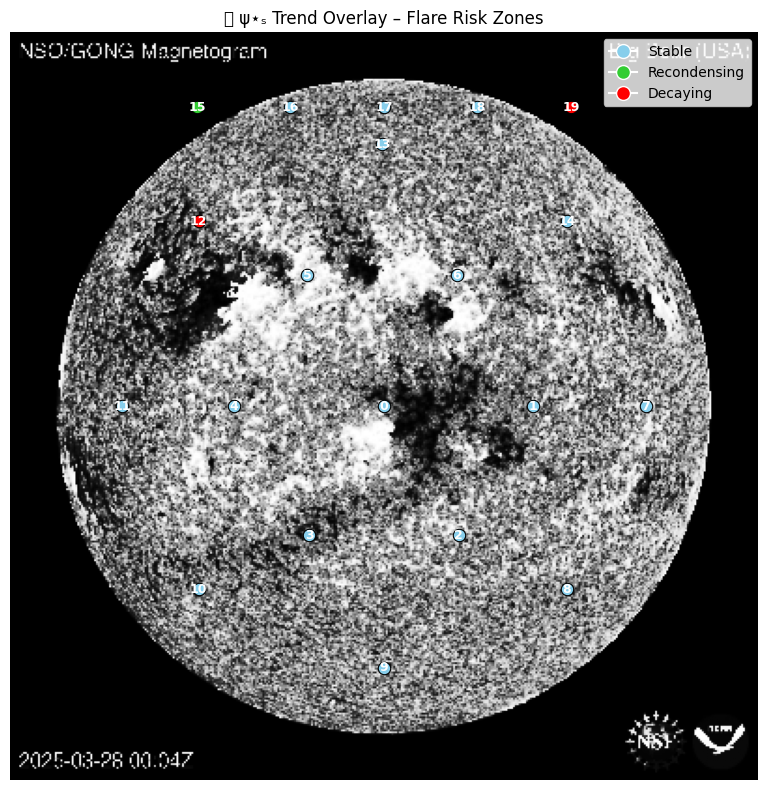

In [55]:
compute_flare_risk_and_show(entropy_timeseries, file_list)

In [56]:
# === 🌌 SECTION 10 — SGCV Fragmentation Map ===

import matplotlib.pyplot as plt

def plot_sgcv_fragmentation_map(entropy_timeseries, file_list):
    # Use last frame
    entropy_vector = entropy_timeseries[-1]
    psi_star = np.exp(-entropy_vector)

    # Thresholds (adjustable)
    intact_thresh = 0.93
    partial_thresh = 0.88
    severe_thresh = 0.82

    # Label nodes based on ψ⋆ₛ
    status_labels = []
    for val in psi_star:
        if val > intact_thresh:
            status_labels.append('🟢 Intact')
        elif val > partial_thresh:
            status_labels.append('🟡 Partial')
        elif val > severe_thresh:
            status_labels.append('🟠 Severe')
        else:
            status_labels.append('🔴 Fragmented')

    # Load image and masks
    img = load_and_preprocess(file_list[-1])
    mask_grid = partition_to_dlsfh_regions(img)

    # Color map
    color_map = {
        '🟢 Intact': 'limegreen',
        '🟡 Partial': 'gold',
        '🟠 Severe': 'orange',
        '🔴 Fragmented': 'red'
    }

    # Plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(img, cmap='gray')
    ax.set_title("🧠 SGCV Fragmentation Map – ψ⋆ₛ Severity")
    ax.axis('off')

    for i, mask in enumerate(mask_grid):
        y, x = np.where(mask)
        if len(x) > 0:
            xc, yc = x.mean(), y.mean()
            ax.scatter(xc, yc, color=color_map[status_labels[i]], s=100, edgecolors='black', linewidths=0.8)
            ax.text(xc, yc, f"{i}", fontsize=9, ha='center', va='center', weight='bold', color='white')

    # Legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label='Intact', markerfacecolor='limegreen', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Partial', markerfacecolor='gold', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Severe', markerfacecolor='orange', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Fragmented', markerfacecolor='red', markersize=10)
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    plt.tight_layout()
    plt.show()

    # Summary print
    print("=== SGCV Fragmentation Status ===")
    for i, status in enumerate(status_labels):
        print(f"Node {i:02}: {status} (ψ⋆ₛ = {psi_star[i]:.4f})")


<ipython-input-56-407d834ec2f6>:60: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


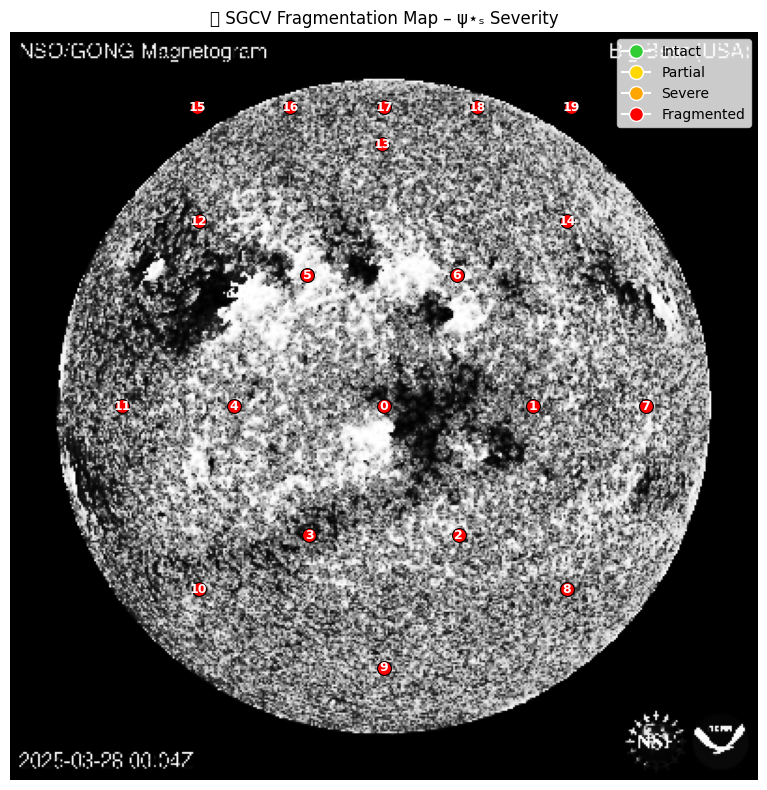

=== SGCV Fragmentation Status ===
Node 00: 🔴 Fragmented (ψ⋆ₛ = 0.0048)
Node 01: 🔴 Fragmented (ψ⋆ₛ = 0.0130)
Node 02: 🔴 Fragmented (ψ⋆ₛ = 0.0119)
Node 03: 🔴 Fragmented (ψ⋆ₛ = 0.0096)
Node 04: 🔴 Fragmented (ψ⋆ₛ = 0.0106)
Node 05: 🔴 Fragmented (ψ⋆ₛ = 0.0046)
Node 06: 🔴 Fragmented (ψ⋆ₛ = 0.0055)
Node 07: 🔴 Fragmented (ψ⋆ₛ = 0.0123)
Node 08: 🔴 Fragmented (ψ⋆ₛ = 0.0153)
Node 09: 🔴 Fragmented (ψ⋆ₛ = 0.0172)
Node 10: 🔴 Fragmented (ψ⋆ₛ = 0.0133)
Node 11: 🔴 Fragmented (ψ⋆ₛ = 0.0119)
Node 12: 🔴 Fragmented (ψ⋆ₛ = 0.0084)
Node 13: 🔴 Fragmented (ψ⋆ₛ = 0.0178)
Node 14: 🔴 Fragmented (ψ⋆ₛ = 0.0135)
Node 15: 🔴 Fragmented (ψ⋆ₛ = 0.4909)
Node 16: 🔴 Fragmented (ψ⋆ₛ = 0.0195)
Node 17: 🔴 Fragmented (ψ⋆ₛ = 0.0172)
Node 18: 🔴 Fragmented (ψ⋆ₛ = 0.0176)
Node 19: 🔴 Fragmented (ψ⋆ₛ = 0.5137)


In [57]:
plot_sgcv_fragmentation_map(entropy_timeseries, file_list)


In [61]:
# === 💾 Section 10.1 — SGCV Fragmentation Log Export ===

import csv
from datetime import datetime

def export_sgcv_fragmentation_to_csv(entropy_timeseries, file_list, filename_prefix="SGCV_Status"):
    # Use last frame
    entropy_vector = entropy_timeseries[-1]
    psi_star = np.exp(-entropy_vector)

    # Status logic
    intact_thresh = 0.93
    partial_thresh = 0.88
    severe_thresh = 0.82

    status_labels = []
    for val in psi_star:
        if val > intact_thresh:
            status_labels.append('🟢 Intact')
        elif val > partial_thresh:
            status_labels.append('🟡 Partial')
        elif val > severe_thresh:
            status_labels.append('🟠 Severe')
        else:
            status_labels.append('🔴 Fragmented')

    # Generate timestamped filename
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{filename_prefix}_{timestamp}.csv"

    # Write CSV
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Node", "Entropy (S)", "ψ⋆ₛ", "SGCV Status"])
        for i, (S, psi, status) in enumerate(zip(entropy_vector, psi_star, status_labels)):
            writer.writerow([i, round(S, 5), round(psi, 5), status])

    print(f"✅ SGCV status exported to: {filename}")


In [62]:
export_sgcv_fragmentation_to_csv(entropy_timeseries, file_list)


✅ SGCV status exported to: SGCV_Status_20250330_182358.csv


In [63]:
# === 🌐 SECTION 11 — Entropy Ring Phase Tracking and Evolution ===

import numpy as np

def detect_entropy_ring_phases(entropy_timeseries, entropy_threshold=0.5, adjacency_required=6):
    phase_states = []
    total_frames = len(entropy_timeseries)

    print("=== 🌀 Entropy Ring Phase Timeline ===")
    print(f"(Using threshold: entropy > {entropy_threshold}, adjacency ≥ {adjacency_required})")

    for frame_idx, entropy_vector in enumerate(entropy_timeseries):
        # Find high-entropy nodes
        high_entropy_nodes = np.where(entropy_vector > entropy_threshold)[0]

        # Track adjacency (circularly)
        adjacency_count = 0
        max_chain = 0

        # Wrap around for circular structure
        for i in range(len(entropy_vector)):
            node_i = i
            is_high = node_i in high_entropy_nodes
            if is_high:
                adjacency_count += 1
                max_chain = max(max_chain, adjacency_count)
            else:
                adjacency_count = 0

        # Wrap check (ring across boundary)
        if entropy_vector[0] > entropy_threshold and entropy_vector[-1] > entropy_threshold:
            chain = 1
            for i in reversed(range(len(entropy_vector))):
                if entropy_vector[i] > entropy_threshold:
                    chain += 1
                else:
                    break
            max_chain = max(max_chain, chain)

        # Determine ring phase state
        if max_chain >= adjacency_required:
            phase_state = '🟠 Ring Forming'
        elif np.count_nonzero(entropy_vector > entropy_threshold) == 0:
            phase_state = '🟢 Dissolved'
        elif 0 < np.count_nonzero(entropy_vector > entropy_threshold) < adjacency_required:
            phase_state = '🟡 Fragmenting'
        else:
            phase_state = '⚪ Stable'

        phase_states.append(phase_state)
        print(f"Frame {frame_idx+1:02}: {phase_state} | High-Entropy Nodes: {len(high_entropy_nodes)} | Max Chain: {max_chain}")

    return phase_states


In [64]:
ring_phases = detect_entropy_ring_phases(entropy_timeseries)

=== 🌀 Entropy Ring Phase Timeline ===
(Using threshold: entropy > 0.5, adjacency ≥ 6)
Frame 01: 🟠 Ring Forming | High-Entropy Nodes: 20 | Max Chain: 21
Frame 02: 🟠 Ring Forming | High-Entropy Nodes: 20 | Max Chain: 21
Frame 03: 🟠 Ring Forming | High-Entropy Nodes: 20 | Max Chain: 21


In [65]:
# === 📊 Section 11.1 — Ring Phase Timeline Plot ===

import matplotlib.pyplot as plt

def plot_entropy_ring_timeline(phase_states):
    color_map = {
        '🟠 Ring Forming': 'orange',
        '⚪ Stable': 'lightgray',
        '🟡 Fragmenting': 'gold',
        '🟢 Dissolved': 'limegreen'
    }

    colors = [color_map[state] for state in phase_states]
    x_labels = [f"{i+1:02}" for i in range(len(phase_states))]

    fig, ax = plt.subplots(figsize=(10, 1.5))
    ax.bar(range(len(phase_states)), [1]*len(phase_states), color=colors, edgecolor='black', width=0.9)

    ax.set_yticks([])
    ax.set_xticks(range(len(phase_states)))
    ax.set_xticklabels(x_labels, rotation=0)
    ax.set_xlabel("Frame Index")
    ax.set_title("🌀 Entropy Ring Phase Evolution Timeline")

    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], color='orange', lw=8, label='🟠 Ring Forming'),
        plt.Line2D([0], [0], color='lightgray', lw=8, label='⚪ Stable'),
        plt.Line2D([0], [0], color='gold', lw=8, label='🟡 Fragmenting'),
        plt.Line2D([0], [0], color='limegreen', lw=8, label='🟢 Dissolved')
    ]
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=4, frameon=False)

    plt.tight_layout()
    plt.show()


<ipython-input-65-dfde5129cb57>:34: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-65-dfde5129cb57>:34: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-65-dfde5129cb57>:34: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-65-dfde5129cb57>:34: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/

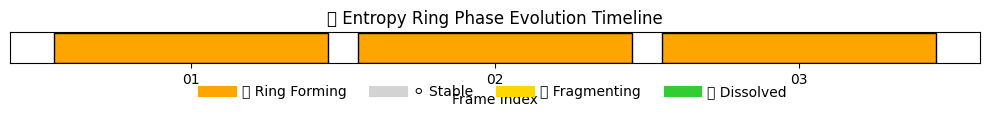

In [66]:
plot_entropy_ring_timeline(ring_phases)

In [ ]:
# === 🧲 Section 11.2 — Entropy Ring Location Overlay ===

import matplotlib.pyplot as plt
import numpy as np

def plot_entropy_ring_overlay(entropy_timeseries, file_list, entropy_threshold=0.5):
    # Use last frame
    entropy_vector = entropy_timeseries[-1]
    high_entropy_nodes = np.where(entropy_vector > entropy_threshold)[0]

    # Load image and mask grid
    img = load_and_preprocess(file_list[-1])
    mask_grid = partition_to_dlsfh_regions(img)

    # Setup plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(img, cmap='gray')
    ax.set_title("🌀 Entropy Ring Detection Overlay")
    ax.axis('off')

    # Plot ring nodes only
    for i in high_entropy_nodes:
        mask = mask_grid[i]
        y, x = np.where(mask)
        if len(x) > 0:
            xc, yc = x.mean(), y.mean()
            ax.scatter(xc, yc, s=150, color='orange', edgecolors='black', linewidths=1.2)
            ax.text(xc, yc, f"{i}", fontsize=9, ha='center', va='center', weight='bold', color='white')

    # Add legend
    ax.legend(
        [plt.Line2D([0], [0], marker='o', color='w', label='High-Entropy Ring Node',
                    markerfacecolor='orange', markersize=12, markeredgecolor='black')],
        ['Entropy > 0.5'],
        loc='upper right'
    )

    plt.tight_layout()
    plt.show()

    print(f"Nodes in entropy ring: {sorted(high_entropy_nodes.tolist())}")


In [ ]:
plot_entropy_ring_overlay(entropy_timeseries, file_list)